In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from behavenet.fitting.utils import get_expt_dir
from behavenet.fitting.utils import get_output_session_dir
from behavenet.fitting.utils import get_best_model_version
from behavenet.fitting.utils import get_lab_example
from behavenet.fitting.utils import read_session_info_from_csv
from behavenet.fitting.utils import find_session_dirs

results_dir = '/home/mattw/results/behavenet_figs/multisession-ae'
save_outputs = False

In [ ]:
sns.set_style('white')
sns.set_context('talk')

## 0. Plot train/val losses as a function of epochs/dataset
For AEs fit on multiple sessions

In [7]:
hparams = {
    'data_dir': '/media/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
#     'experiment_name': 'session_io',
    'model_class': 'ae',
    'n_ae_latents': 16,
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': 'mSM30',
    'session': 'all',
    'multisession': 0}
model_type = 'conv'

metrics_df = []

hparams['model_type'] = model_type   
hparams['session_dir'], _ = get_output_session_dir(hparams)
expt_dir = get_expt_dir(hparams)
model_version = get_best_model_version(expt_dir)
metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
metrics = pd.read_csv(metric_file)

sess_ids = read_session_info_from_csv(os.path.join(
    expt_dir, model_version[0], 'session_info.csv'))
sess_ids_strs = []
for sess_id in sess_ids:
    sess_ids_strs.append(str('%s/%s' % (sess_id['animal'], sess_id['session'])))
    
for i, row in metrics.iterrows():
    dataset = 'all' if row['dataset'] == -1 else sess_ids_strs[row['dataset']]
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['val_loss'],
        'dtype': 'val',
        'model_type': model_type,
    }, index=[0]))
    metrics_df.append(pd.DataFrame({
        'dataset': dataset,
        'epoch': row['epoch'],
        'loss': row['tr_loss'],
        'dtype': 'train',
        'model_type': model_type,
    }, index=[0]))
    if 'test_loss' in row:
        metrics_df.append(pd.DataFrame({
            'dataset': dataset,
            'epoch': row['epoch'],
            'loss': row['test_loss'],
            'dtype': 'test',
            'model_type': model_type,
        }, index=[0]))
metrics_df = pd.concat(metrics_df)    

### plot validation data for ind/comb datasets as a function of epochs

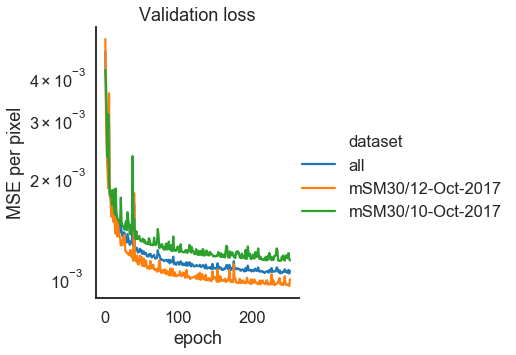

In [8]:
sns.set_style('white')
sns.set_context('talk')

# data_queried = metrics[~pd.notna(metrics.test_loss)]
data_queried = metrics_df[
    (metrics_df.dtype=='val') &
    (metrics_df.epoch>0) & 
    ~pd.isna(metrics_df.loss)]

y_axis = 'loss' # 'test_loss' | 'test_r2'
plot_type = 'line'
hue = 'dataset'
x_axis = 'epoch' # 'layers' | 'layer_size' | 'pred' | 'lags'

splt = sns.relplot(
    x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
splt.ax.set_yscale('log')
splt.ax.set_ylabel('MSE per pixel')
#     splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#     splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
#     splt._legend.set_title('Model\ntype')
    
plt.title('Validation loss')
if save_outputs:
    save_file = os.path.join(
        results_dir, 
        str('%s_%02i-dim_%s' % (hparams['lab'], hparams['n_ae_latents'], hparams['animal'])))
else:
    save_file = None
    
if save_file is not None:
    plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
    
plt.show()

# 1. Plot val losses for different networks
These cells can be used to compare validation loss of a single session when using an ae trained specifically on that session, on all sessions from one animal, on all sessions from one experiment, etc.

In [ ]:
def plot_loss_curve(df, dtype='val', save_fig=False, results_dir=None, hparams=None):

    data_queried = df[
        (metrics_df.dtype==dtype) 
        & (metrics_df.epoch>20)
        & ~pd.isna(metrics_df.loss)
        & (metrics_df.datasets != 'all//test_pt')
    ]

    y_axis = 'loss' # 'test_loss' | 'test_r2'
    plot_type = 'line'
    hue = 'datasets'
    x_axis = 'time' # 'layers' | 'layer_size' | 'pred' | 'lags'

    splt = sns.relplot(
        x=x_axis, y=y_axis, hue=hue, kind=plot_type, data=data_queried)
    splt.ax.set_yscale('log')
    splt.ax.set_ylabel('MSE per pixel')
    if x_axis == 'time':
        splt.ax.set_xlabel('Time (hours)')
    elif x_axis == 'epoch':
        splt.ax.set_xlabel('Epochs')
    #     splt.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #     splt.ax.ticklabel_format(axis='y', style='sci', scilimits=(1, 2))  # (1, 2) a hack
    #     splt._legend.set_title('Model\ntype')

    plt.title('%s loss' % dtype.capitalize())
    if save_fig:
        save_file = os.path.join(
            results_dir, 
            str('%s_%02i-dim_%s_%s' % 
                (hparams['lab'], hparams['n_ae_latents'], hparams['animal'], hparams['session'])))
    else:
        save_file = None
    if save_file is not None:
        plt.savefig(save_file + '.jpg', dpi=300, format='jpeg')   
    plt.show()
    return splt

### load results from all models

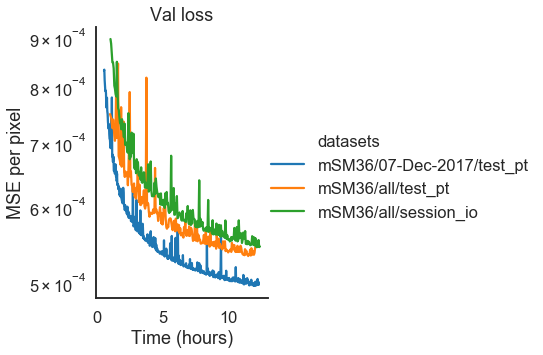

In [56]:
hparams = {
    'data_dir': '/home/mattw/data',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet',
    'experiment_name': 'test_pt',
    'model_class': 'ae',
    'n_ae_latents': 16,
    'lab': 'musall',
    'expt': 'vistrained',
    'animal': None,
    'session': None}
experiment_names = ['test_pt', 'session_io']
an_sess = [
#     ('mSM30', '10-Oct-2017'),
#     ('mSM30', '12-Oct-2017'),
#     ('mSM34', '01-Dec-2017'),
#     ('mSM34', '02-Dec-2017'),
#     ('mSM36', '05-Dec-2017'),
    ('mSM36', '07-Dec-2017'),
#     ('mSM46', '01-Dec-2017'),
#     ('mSM46', '13-Jan-2018'),
#     ('mSM57', '02-Feb-2018'),
#     ('mSM57', '08-Feb-2018')
]

for animal, session in an_sess:
    
    # load all ae models that used this session for fitting
    hparams['animal'] = animal
    hparams['session'] = session
    model_types = ['conv'] #['conv', 'linear']

    ids = {s: hparams[s] for s in ['lab', 'expt', 'animal', 'session']}
    session_dirs, session_strs = find_session_dirs(hparams)
    metrics_df = []
    for session_dir, session_str in zip(session_dirs, session_strs):
        hparams['session_dir'] = session_dir
        for model_type in model_types:
            for expt_name in experiment_names:

                hparams['model_type'] = model_type   
                hparams['experiment_name'] = expt_name
                expt_dir = get_expt_dir(hparams)
                if not os.path.exists(expt_dir):
                    continue
                model_version = get_best_model_version(expt_dir)
                metric_file = os.path.join(expt_dir, model_version[0], 'metrics.csv')
                metrics = pd.read_csv(metric_file)

                # get dataset index
                if session_dir.find('multi') > -1:
                    sess_ids = read_session_info_from_csv(os.path.join(
                        expt_dir, model_version[0], 'session_info.csv'))
                    dataset = None
                    for i, sess_id in enumerate(sess_ids):
                        sess_id.pop('tt_save_path', None)
                        if sess_id == ids:
                            dataset = i
                    if dataset is None:
                        raise Exception            
                else:
                    dataset = 0

                first_timestamp = None
                for i, row in metrics.iterrows():

                    # just get dataset we're interested in if a multi-session
                    if session_dir.find('multi') > -1 and row['dataset'] != dataset:
                        continue

                    if first_timestamp is None:
                        first_timestamp = pd.to_datetime(row['created_at'])

                    elapsed_time = pd.to_datetime(row['created_at']) - first_timestamp
                    elapsed_time_h = elapsed_time.seconds / 3600  # to hours
                    datasets = str('%s/%s' % (session_str['animal'], session_str['session']))
                    if len(experiment_names) > 1:
                        datasets = str('%s/%s' % (datasets, expt_name))
                    metrics_df.append(pd.DataFrame({
                        'datasets': datasets,
                        'epoch': row['epoch'],
                        'time': elapsed_time_h,
                        'loss': row['val_loss'],
                        'dtype': 'val',
                        'model_type': model_type,
                    }, index=[0]))
                    metrics_df.append(pd.DataFrame({
                        'datasets': datasets,
                        'epoch': row['epoch'],
                        'time': elapsed_time_h,
                        'loss': row['tr_loss'],
                        'dtype': 'train',
                        'model_type': model_type,
                    }, index=[0]))
                    if 'test_loss' in row:
                        metrics_df.append(pd.DataFrame({
                            'datasets': datasets,
                            'epoch': row['epoch'],
                            'time': elapsed_time_h,
                            'loss': row['test_loss'],
                            'dtype': 'test',
                            'model_type': model_type,
                        }, index=[0]))
                    
    metrics_df = pd.concat(metrics_df)
    plot_loss_curve(
        metrics_df, dtype='val', 
        save_fig=save_outputs, results_dir=results_dir, hparams=hparams)

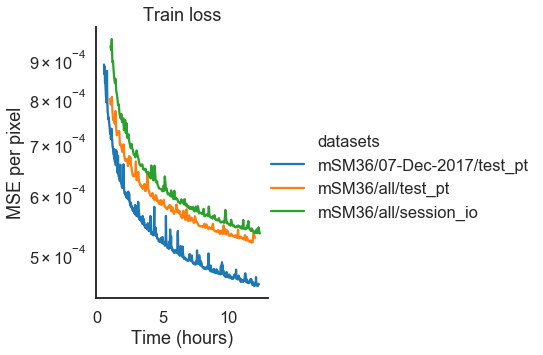

In [57]:
plot_loss_curve(
    metrics_df, dtype='train', 
    save_fig=save_outputs, results_dir=results_dir, hparams=hparams)

# 3. Make reconstruction movies

### all models for a single session/tt experiment

In [58]:
from behavenet.analyses.ae_utils import make_ae_reconstruction_movie_multisession
from behavenet.data.data_generator import ConcatSessionsGenerator

lab = 'musall'
version = 'best'
hparams = {
    'data_dir': '/home/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'experiment_name': None,
    'model_class': 'ae',
    'model_type': 'conv'}
get_lab_example(hparams, lab)
hparams['lab'] = lab
hparams['expt'] = 'vistrained'
hparams['animal'] = 'mSM36'
hparams['session'] = '05-Dec-2017'


data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals_list=[['images']], 
    transforms_list=[[None]], 
    paths_list=[[os.path.join(
        hparams['data_dir'], hparams['lab'], hparams['expt'], 
        hparams['animal'], hparams['session'], 'data.hdf5')]],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.datasets[0].batch_indxs['test'][4]
batch = data_generator.datasets[0][trial]['images'][:400]

save_file = os.path.join(
    results_dir, 
    str('%s_%02i-dim_%s_%s_bn' % 
        (hparams['lab'], hparams['n_ae_latents'], hparams['animal'], hparams['session'])))

# now define where the model comes from
# hparams['expt'] = 'vistrained'
# hparams['animal'] = 'all'
# hparams['session'] = ''
# hparams['multisession'] = 1         
# hparams['session_dir'], _ = get_output_session_dir(hparams) 

make_ae_reconstruction_movie_multisession_all(
    hparams, version=version, batch=batch, save_file=save_file, trial=trial)   

OSError: Unable to open file (unable to open file: name = '/home/mattw/data/musall/vistrained/mSM36/05-Dec-2017/data.hdf5', errno = 2, error message = 'No such file or directory', flags = 40, o_flags = 0)

### specify models

Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/07-Dec-2017/ae/conv/16_latents/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/16_latents/test_pt/version_0/meta_tags.pkl
Loading model defined in /home/mattw/results/behavenet/musall/vistrained/mSM36/multisession-00/ae/conv/16_latents/session_io/version_0/meta_tags.pkl
video saved to /home/mattw/results/behavenet_figs/multisession-ae/musall_16-dim_mSM36_07-Dec-2017_session-io.mp4


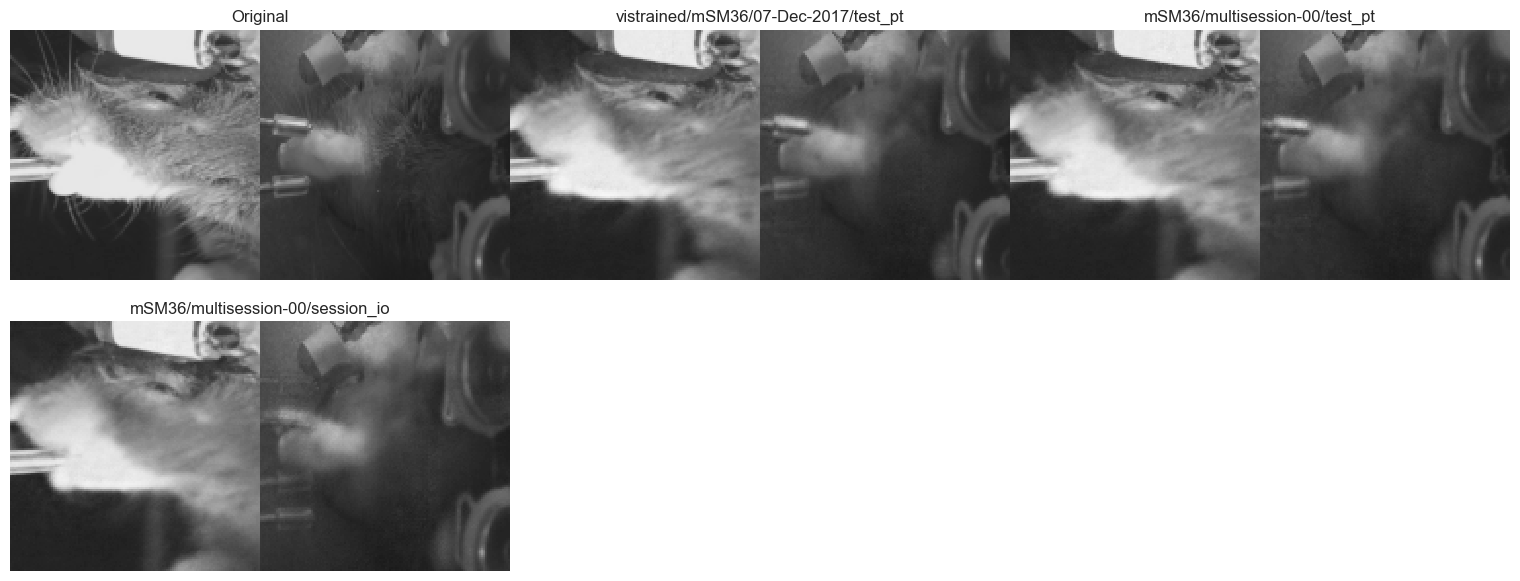

In [60]:
from behavenet.analyses.ae_utils import rotate
from behavenet.analyses.ae_utils import _make_ae_reconstruction_movie_multisession
from behavenet.analyses.ae_utils import get_best_model_and_data
from behavenet.analyses.ae_utils import get_reconstruction
from behavenet.data.data_generator import ConcatSessionsGenerator
from behavenet.models import AE

lab = 'musall'
version = 'best'
hparams = {
    'data_dir': '/media/mattw/data/',  # might be a different path than what is saved in hparams
    'tt_save_path': '/home/mattw/results/behavenet/',
    'experiment_name': 'test_pt_bn',
    'model_class': 'ae',
    'model_type': 'conv'}
get_lab_example(hparams, lab)
hparams['lab'] = lab
hparams['expt'] = 'vistrained'
hparams['animal'] = 'mSM36'
hparams['session'] = '07-Dec-2017'
   
# hparams, signals, transforms, paths = get_data_generator_inputs(hparams, [hparams])
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], hparams, 
    signals_list=[['images']], 
    transforms_list=[[None]], 
    paths_list=[[os.path.join(
        hparams['data_dir'], hparams['lab'], hparams['expt'], 
        hparams['animal'], hparams['session'], 'data.hdf5')]],
    device='cpu', as_numpy=False, batch_load=True, rng_seed=0)
trial = data_generator.datasets[0].batch_indxs['test'][4]
batch = data_generator.datasets[0][trial]['images'][:400]

expt_ids = [
    ({'lab': 'musall', 'expt': 'vistrained', 'animal': hparams['animal'], 
      'session': hparams['session'], 'multisession': None},
     'test_pt'),
    ({'lab': 'musall', 'expt': 'vistrained', 'animal': hparams['animal'], 
      'session': 'all', 'multisession': 0},
     'test_pt'),
    ({'lab': 'musall', 'expt': 'vistrained', 'animal': hparams['animal'], 
      'session': 'all', 'multisession': 0},
     'session_io'),
]

save_file = os.path.join(
    results_dir, 
    str('%s_%02i-dim_%s_%s_session-io' % 
        (hparams['lab'], hparams['n_ae_latents'], hparams['animal'], hparams['session'])))

# loop over different sessions
ims_recon_ae = []
sess_strs = []
for sess_id, expt_name in expt_ids:

    hparams['lab'] = sess_id['lab']
    hparams['expt'] = sess_id['expt']
    hparams['animal'] = sess_id['animal']
    hparams['session'] = sess_id['session']
    hparams['multisession'] = sess_id['multisession']
    hparams['experiment_name'] = expt_name

    if sess_id.get('multisession', None) is not None:
        multisession = str('multisession-%02i' % sess_id['multisession'])
    if sess_id['expt'] == 'all':
        sess_str = os.path.join(multisession)
    elif sess_id['animal'] == 'all':
        sess_str = os.path.join(sess_id['expt'], multisession)
    elif sess_id['session'] == 'all':
        sess_str = os.path.join(
#             sess_id['expt'], sess_id['animal'], multisession)
            sess_id['animal'], multisession)
    else:
        sess_str = os.path.join(
            sess_id['expt'], sess_id['animal'], sess_id['session'])
    sess_str = os.path.join(sess_str, expt_name)

    # build model(s) if they exist in the specified tt experiment
    try:
        model_ae, _ = get_best_model_and_data(
            hparams, AE, load_data=False, version=version)
        # push images through decoder
        if batch is None:
            raise NotImplementedError
        else:
            ims_orig_pt = batch
        ims_recon_ae.append(get_reconstruction(model_ae, ims_orig_pt, dataset=0))
        sess_strs.append(sess_str)
    except Exception:  # why doesn't StopIteration work here?
        print('Model does not exist for %s; skipping' % sess_str)
        continue

if len(ims_recon_ae) == 0:
    raise Exception('No models found')

# rotate first channel of musall data
if hparams['lab'] == 'musall':
    ims_orig = rotate(ims_orig_pt.cpu().detach().numpy())
    for i, ims_recon in enumerate(ims_recon_ae):
        ims_recon_ae[i] = rotate(ims_recon)
else:
    ims_orig = ims_orig_pt.cpu().detach().numpy()

_make_ae_reconstruction_movie_multisession(
    ims_orig=ims_orig,
    ims_recon_ae=ims_recon_ae,
    panel_titles=sess_strs,
    save_file=save_file,
    frame_rate=hparams['frame_rate'])